In [1]:
import os
import numpy as np
import pandas as pd
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
from numpy import *
from sklearn import *
from PSO_IBK2 import *
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import pickle
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
import time
from imblearn.over_sampling import SMOTE, SVMSMOTE, ADASYN, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter

In [2]:
Ascent_whole = pd.read_csv ('Ascent.csv')

In [3]:
#Split X and Y
AX= Ascent_whole.drop('DISCONT',axis=1)
AY = Ascent_whole['DISCONT']
print(AX.shape)

(476, 119)


In [4]:
Atrain, Atest, AtrainY, AtestY = model_selection.train_test_split(AX, AY, test_size = 0.3, random_state=42)

In [5]:
#Separate columns for encoding and scaling

#Scale
Atrain_to_scale = Atrain.select_dtypes(exclude = 'object')
Atest_to_scale = Atest.select_dtypes(exclude = 'object')

#Encode
Atrain_to_encode = Atrain.select_dtypes('object')
Atest_to_encode = Atest.select_dtypes('object')

In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
scaler = StandardScaler()
enc    = OneHotEncoder(handle_unknown='ignore',sparse=False)

In [7]:
#Scale
Atrain_scale_columns_names = []
for col in Atrain_to_scale.columns: 
    Atrain_scale_columns_names.append(col)
Atest_scale_columns_names = []
for col in Atest_to_scale.columns: 
    Atest_scale_columns_names.append(col)
    
#Encode    
Atrain_encode_columns_names = []
for col in Atrain_to_encode.columns: 
    Atrain_encode_columns_names.append(col)
Atest_encode_columns_names = []
for col in Atest_to_encode.columns: 
    Atest_encode_columns_names.append(col)

In [8]:
# Scale and Encode Separate Columns
#Scale
scaler.fit(Atrain[Atrain_scale_columns_names]) 
Atrain_scaled_columns  = scaler.transform(Atrain[Atrain_scale_columns_names])
Atest_scaled_columns  = scaler.transform(Atest[Atest_scale_columns_names])

#Encode
enc.fit(Atrain[Atrain_encode_columns_names])
Atrain_encoded_columns = enc.transform((Atrain[Atrain_encode_columns_names]))
Atest_encoded_columns = enc.transform(Atest[Atest_encode_columns_names])

In [9]:
# Concatenate (Column-Bind) Processed Columns Back Together
#Train
New_Atrain = np.concatenate([Atrain_scaled_columns,Atrain_encoded_columns], axis=1)
#Test
New_Atest = np.concatenate([Atest_scaled_columns,Atest_encoded_columns], axis=1)

In [10]:
print(New_Atrain.shape, New_Atest.shape)

(333, 176) (143, 176)


In [11]:
KPCA = decomposition.KernelPCA(kernel= 'rbf', n_components=100) 

KPCA.fit(New_Atrain)
Atrain = KPCA.transform(New_Atrain)
Atest = KPCA.transform(New_Atest)

In [12]:
#Before SMOTE
Acounter = Counter(AtrainY)
print(Acounter)

Counter({0: 258, 1: 75})


In [13]:
#After SMOTE
from collections import Counter
sm =  SVMSMOTE(random_state = 42)

Atrain, AtrainY = sm.fit_resample(Atrain, AtrainY)
Acounter = Counter(AtrainY)
print(Acounter)

Counter({0: 258, 1: 258})


In [14]:
#Train
Atrain = np.array(Atrain)
AtrainY = np.array(AtrainY)

#Test
Atest = np.array(Atest)
AtestY = np.array(AtestY)

In [15]:
AtrainY = np.array(pd.Categorical(AtrainY))
AtestY = np.array(pd.Categorical(AtestY))

AtrainY = np.array(AtrainY.astype(int))
AtestY = np.array(AtestY.astype(int))

In [16]:
parameter = {'C': [10], 'probability':[True], 'kernel':['rbf'], 'random_state': [42]}
aSV = model_selection.GridSearchCV(svm.SVC(),parameter, cv=5, n_jobs=-1)

aSV.fit(Atrain, AtrainY)
SAmodel = aSV.predict_proba(Atest)    
SA_auc  = metrics.roc_auc_score(AtestY, SAmodel[:,1])
SAfpr, SAtpr, SAthresholds = metrics.roc_curve(AtestY, SAmodel[:,1])
SA_auprc  = metrics.average_precision_score(AtestY, SAmodel[:,1])
SAr, SAp, SAthresholds1 = metrics.precision_recall_curve(AtestY, SAmodel[:,1])
    
print('AUC: ', SA_auc, 'AUPRC: ', SA_auprc)
print(aSV.best_params_)

AUC:  0.8536873156342182 AUPRC:  0.5827107171114151
{'C': 10, 'kernel': 'rbf', 'probability': True, 'random_state': 42}


In [17]:
parameter = {'n_estimators': [500], 'max_depth': [None], 'ccp_alpha':[0.0], 'max_features': ['log2'], 'random_state': [42]}
aRF = model_selection.GridSearchCV(ensemble.RandomForestClassifier(),parameter, cv=5, n_jobs=-1)

aRF.fit(Atrain, AtrainY)
RAmodel = aRF.predict_proba(Atest)    
RAauc  = metrics.roc_auc_score(AtestY, RAmodel[:,1])
RAfpr, RAtpr, RAthresholds = metrics.roc_curve(AtestY, RAmodel[:,1])
RAauprc  = metrics.average_precision_score(AtestY, RAmodel[:,1])
RAr, RAp, RAthresholds1 = metrics.precision_recall_curve(AtestY, RAmodel[:,1])
    
print('AUC: ', RAauc, 'AUPRC: ', RAauprc)
print(aRF.best_params_)

AUC:  0.7452802359882006 AUPRC:  0.4316237416106499
{'ccp_alpha': 0.0, 'max_depth': None, 'max_features': 'log2', 'n_estimators': 500, 'random_state': 42}


In [18]:
parameter = {'n_estimators': [500], 'max_depth': [-1], 'learning_rate':[0.1], 'random_state': [42]}
aLGB = model_selection.GridSearchCV(lgb.LGBMClassifier(),parameter, cv=5, n_jobs=-1)
aLGB.fit(Atrain, AtrainY)

LAmodel = aLGB.predict_proba(Atest)    
LAauc  = metrics.roc_auc_score(AtestY, LAmodel[:,1])
LAfpr, LAtpr, LAthresholds = metrics.roc_curve(AtestY, LAmodel[:,1])
LAauprc  = metrics.average_precision_score(AtestY, LAmodel[:,1])
LAr, LAp, LAthresholds1 = metrics.precision_recall_curve(AtestY, LAmodel[:,1])
    
print('AUC: ', LAauc, 'AUPRC: ', LAauprc)
print(aLGB.best_params_)

AUC:  0.7584070796460177 AUPRC:  0.47302697086354273
{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 500, 'random_state': 42}


In [19]:
parameter = {'n_estimators': [100], 'max_depth': [4], 'learning_rate':[0.5], 'random_state': [42]}
aXGB = model_selection.GridSearchCV(xgb.XGBClassifier(),parameter, cv=5, n_jobs=-1)
aXGB.fit(Atrain, AtrainY)

XAmodel = aXGB.predict_proba(Atest)    
XAauc  = metrics.roc_auc_score(AtestY, XAmodel[:,1])
XAfpr, XAtpr, XAthresholds = metrics.roc_curve(AtestY, XAmodel[:,1])
XAauprc  = metrics.average_precision_score(AtestY, XAmodel[:,1])
XAr, XAp, XAthresholds1 = metrics.precision_recall_curve(AtestY, XAmodel[:,1])
    
print('AUC: ', XAauc, 'AUPRC: ', XAauprc)
print(aXGB.best_params_)

AUC:  0.7474926253687316 AUPRC:  0.4134815149162482
{'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 100, 'random_state': 42}


In [20]:
parameter = {'n_estimators': [500], 'max_depth': [4], 'learning_rate':[0.1], 'random_state':[42]}
aCB = model_selection.GridSearchCV(cb.CatBoostClassifier(),parameter, cv=5, n_jobs=-1)
aCB.fit(Atrain, AtrainY)
CAmodel = aCB.predict_proba(Atest)   
    
CAauc  = metrics.roc_auc_score(AtestY, CAmodel[:,1])
CAfpr, CAtpr, CAthresholds = metrics.roc_curve(AtestY, CAmodel[:,1])
CAauprc  = metrics.average_precision_score(AtestY, CAmodel[:,1])
CAr, CAp, CAthresholds1 = metrics.precision_recall_curve(AtestY, CAmodel[:,1])
    
print('AUC: ', CAauc, 'AUPRC: ', CAauprc)
print(aCB.best_params_)

0:	learn: 0.6568132	total: 150ms	remaining: 1m 14s
1:	learn: 0.6336493	total: 153ms	remaining: 38.2s
2:	learn: 0.6059699	total: 158ms	remaining: 26.1s
3:	learn: 0.5868790	total: 162ms	remaining: 20.1s
4:	learn: 0.5656923	total: 167ms	remaining: 16.5s
5:	learn: 0.5523945	total: 171ms	remaining: 14.1s
6:	learn: 0.5354243	total: 176ms	remaining: 12.4s
7:	learn: 0.5222248	total: 181ms	remaining: 11.1s
8:	learn: 0.5056975	total: 185ms	remaining: 10.1s
9:	learn: 0.4875733	total: 191ms	remaining: 9.34s
10:	learn: 0.4740603	total: 195ms	remaining: 8.66s
11:	learn: 0.4640237	total: 199ms	remaining: 8.1s
12:	learn: 0.4586725	total: 204ms	remaining: 7.64s
13:	learn: 0.4496769	total: 208ms	remaining: 7.21s
14:	learn: 0.4411986	total: 211ms	remaining: 6.84s
15:	learn: 0.4283975	total: 216ms	remaining: 6.53s
16:	learn: 0.4183311	total: 220ms	remaining: 6.24s
17:	learn: 0.4099462	total: 223ms	remaining: 5.98s
18:	learn: 0.4019909	total: 227ms	remaining: 5.74s
19:	learn: 0.3940465	total: 230ms	remaini

174:	learn: 0.0189849	total: 841ms	remaining: 1.56s
175:	learn: 0.0187253	total: 846ms	remaining: 1.56s
176:	learn: 0.0184276	total: 850ms	remaining: 1.55s
177:	learn: 0.0183232	total: 855ms	remaining: 1.55s
178:	learn: 0.0179853	total: 859ms	remaining: 1.54s
179:	learn: 0.0177313	total: 864ms	remaining: 1.53s
180:	learn: 0.0173637	total: 869ms	remaining: 1.53s
181:	learn: 0.0170016	total: 874ms	remaining: 1.53s
182:	learn: 0.0168523	total: 877ms	remaining: 1.52s
183:	learn: 0.0165438	total: 882ms	remaining: 1.51s
184:	learn: 0.0162850	total: 885ms	remaining: 1.51s
185:	learn: 0.0161417	total: 889ms	remaining: 1.5s
186:	learn: 0.0159968	total: 893ms	remaining: 1.49s
187:	learn: 0.0157384	total: 897ms	remaining: 1.49s
188:	learn: 0.0156164	total: 901ms	remaining: 1.48s
189:	learn: 0.0153930	total: 905ms	remaining: 1.48s
190:	learn: 0.0152197	total: 909ms	remaining: 1.47s
191:	learn: 0.0150422	total: 913ms	remaining: 1.46s
192:	learn: 0.0147934	total: 917ms	remaining: 1.46s
193:	learn: 0

350:	learn: 0.0038768	total: 1.53s	remaining: 652ms
351:	learn: 0.0038548	total: 1.54s	remaining: 647ms
352:	learn: 0.0038310	total: 1.54s	remaining: 643ms
353:	learn: 0.0038128	total: 1.55s	remaining: 638ms
354:	learn: 0.0037915	total: 1.55s	remaining: 634ms
355:	learn: 0.0037793	total: 1.55s	remaining: 629ms
356:	learn: 0.0037687	total: 1.56s	remaining: 624ms
357:	learn: 0.0037533	total: 1.56s	remaining: 620ms
358:	learn: 0.0037351	total: 1.57s	remaining: 615ms
359:	learn: 0.0037128	total: 1.57s	remaining: 611ms
360:	learn: 0.0036873	total: 1.57s	remaining: 607ms
361:	learn: 0.0036598	total: 1.58s	remaining: 602ms
362:	learn: 0.0036372	total: 1.58s	remaining: 598ms
363:	learn: 0.0036193	total: 1.59s	remaining: 593ms
364:	learn: 0.0035873	total: 1.59s	remaining: 588ms
365:	learn: 0.0035751	total: 1.59s	remaining: 584ms
366:	learn: 0.0035501	total: 1.6s	remaining: 579ms
367:	learn: 0.0035301	total: 1.6s	remaining: 575ms
368:	learn: 0.0035071	total: 1.61s	remaining: 570ms
369:	learn: 0.

In [21]:
parameter = {'n_neighbors': [5], 'weights': ['distance'], 'algorithm':['auto']}
aKNN = model_selection.GridSearchCV(neighbors.KNeighborsClassifier(),parameter, cv=5, n_jobs=-1)
aKNN.fit(Atrain, AtrainY)
KAmodel = aKNN.predict_proba(Atest)   
    
KAauc  = metrics.roc_auc_score(AtestY, KAmodel[:,1])
KAfpr, KAtpr, KAthresholds = metrics.roc_curve(AtestY, KAmodel[:,1])
KAauprc  = metrics.average_precision_score(AtestY, KAmodel[:,1])
KAr, KAp, KAthresholds1 = metrics.precision_recall_curve(AtestY, KAmodel[:,1])
    
print('AUC: ', KAauc, 'AUPRC: ', KAauprc)
print(aKNN.best_params_)

AUC:  0.6718289085545723 AUPRC:  0.32415851036641147
{'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'}


In [22]:
from sklearn.gaussian_process.kernels import RBF

In [25]:
Kernel = 1.0 * RBF(1.0)
parameter = {'n_restarts_optimizer': [0], 'max_iter_predict': [100], 
             'warm_start':[True], 'multi_class':['one_vs_rest'], 'random_state': [42]}
aGPC = model_selection.GridSearchCV(gaussian_process.GaussianProcessClassifier(kernel=Kernel),
                                    parameter, cv=5, n_jobs=-1)
aGPC.fit(Atrain, AtrainY)
GAmodel = aGPC.predict_proba(Atest)   
    
GAauc  = metrics.roc_auc_score(AtestY, GAmodel[:,1])
GAfpr, GAtpr, GAthresholds = metrics.roc_curve(AtestY, GAmodel[:,1])
GAauprc  = metrics.average_precision_score(AtestY, GAmodel[:,1])
GAr, GAp, GAthresholds1 = metrics.precision_recall_curve(AtestY, GAmodel[:,1])
    
print('AUC: ', GAauc, 'AUPRC: ', GAauprc)
print(aGPC.best_params_)

AUC:  0.8589970501474926 AUPRC:  0.5510707195880544
{'max_iter_predict': 100, 'multi_class': 'one_vs_rest', 'n_restarts_optimizer': 0, 'random_state': 42, 'warm_start': True}


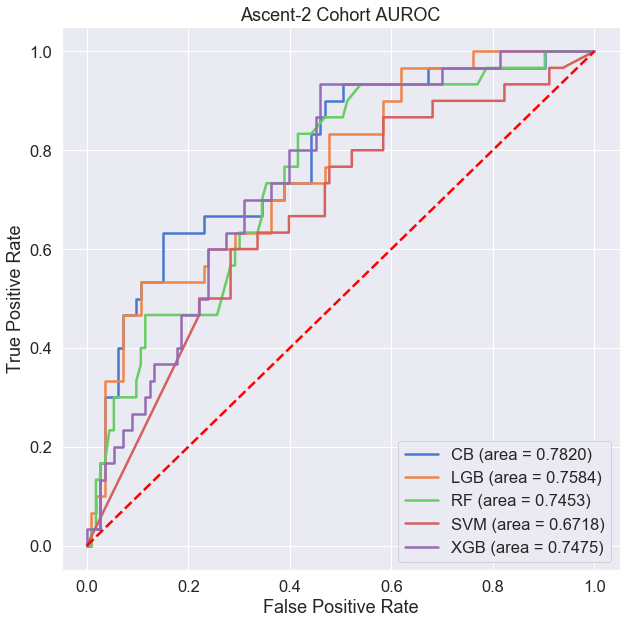

In [27]:
plt.figure(figsize=(10,10))
plt.plot(CAfpr, CAtpr, label = 'CB (area = %0.4f)' % CAauc)
plt.plot(LAfpr, LAtpr, label = 'LGB (area = %0.4f)' % LAauc)
plt.plot(RAfpr, RAtpr, label = 'RF (area = %0.4f)' % RAauc)
plt.plot(KAfpr, KAtpr, label = 'SVM (area = %0.4f)' % KAauc)
plt.plot(XAfpr, XAtpr, label = 'XGB (area = %0.4f)' % XAauc)

plt.plot([0,1], [0,1], 'r--')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ascent-2 Cohort AUROC')
plt.legend(loc = 'lower right')
#plt.savefig("1ASCENT_KPCA.png", format="png")
plt.show()

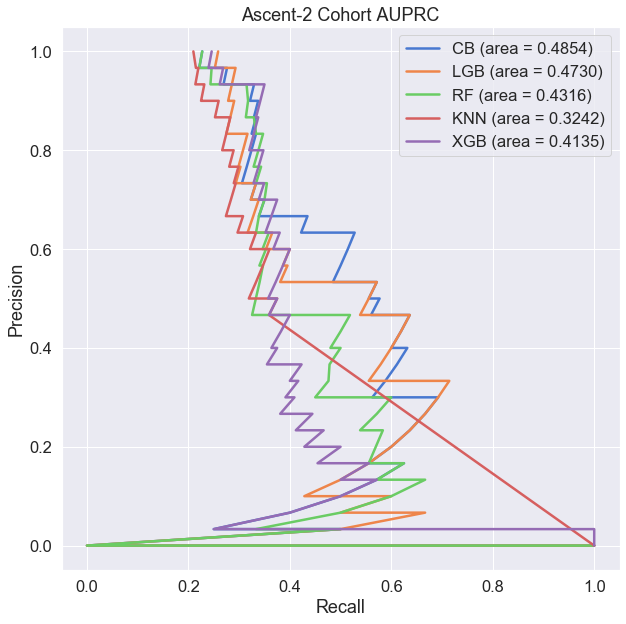

In [28]:
plt.figure(figsize=(10,10))
plt.plot(CAr, CAp, label = 'CB (area = %0.4f)' % CAauprc)
plt.plot(LAr, LAp, label = 'LGB (area = %0.4f)' % LAauprc)
plt.plot(RAr, RAp, label = 'RF (area = %0.4f)' % RAauprc)
plt.plot(KAr, KAp, label = 'KNN (area = %0.4f)' % KAauprc)
plt.plot(XAr, XAp, label = 'XGB (area = %0.4f)' % XAauprc)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Ascent-2 Cohort AUPRC')
plt.legend(loc = 'upper right')
#plt.savefig("1ASCENT_KPCAprc.png", format="png")
plt.show()